In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import StandardScaler

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Class,Count
0,0,5734
1,1,3


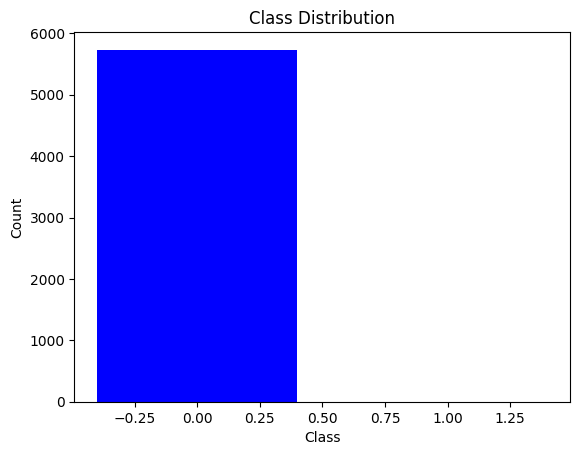

,Class,Count
0,1,5737
1,0,5734


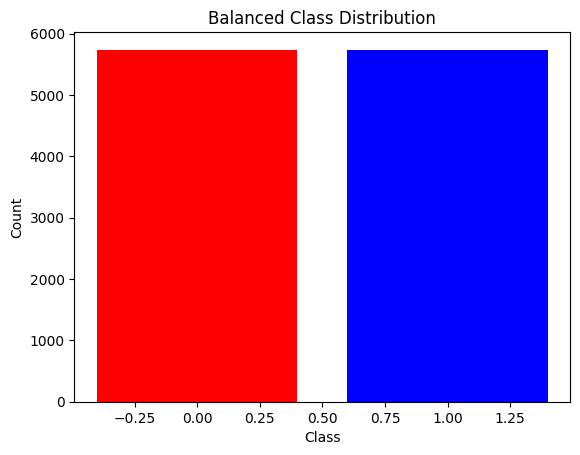

,precision,recall,f1-score,support
0,1.0,1.0,1.0,1190.0
1,1.0,1.0,1.0,1105.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,2295.0
weighted avg,1.0,1.0,1.0,2295.0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13916\1429661119.py:77: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13916\1429661119.py:78: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



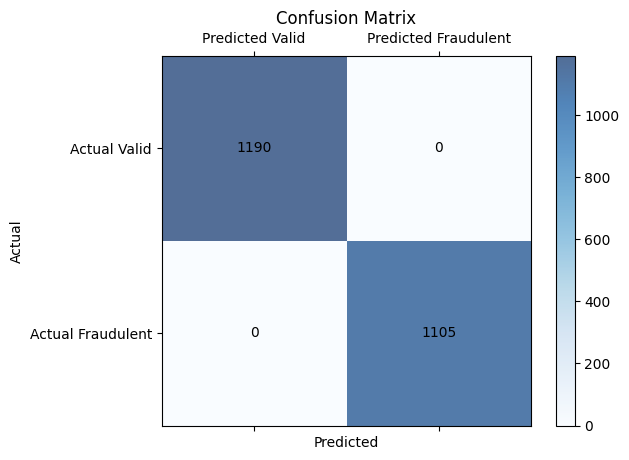

In [10]:
# Load dataset
df = pd.read_csv('c.csv')

# Display the first few rows of the dataset
display(df.head())

# Check the distribution of classes
class_counts = df['Class'].value_counts()
class_counts_df = pd.DataFrame(class_counts).reset_index()
class_counts_df.columns = ['Class', 'Count']
display(class_counts_df)

# Visualize class distribution
fig, ax = plt.subplots()
ax.bar(class_counts_df['Class'], class_counts_df['Count'], color=['blue', 'red'])
ax.set_title('Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.show()

# Data preprocessing
X = df.drop('Class', axis=1)
y = df['Class']

# Manually resample the dataset to balance the classes
# Duplicate the minority class samples
df_minority = df[df['Class'] == 1]
df_balanced = pd.concat([df, df_minority.sample(n=5734, replace=True, random_state=42)], axis=0)

X_balanced = df_balanced.drop('Class', axis=1)
y_balanced = df_balanced['Class']

# Check the new class distribution
balanced_class_counts = y_balanced.value_counts()
balanced_class_counts_df = pd.DataFrame(balanced_class_counts).reset_index()
balanced_class_counts_df.columns = ['Class', 'Count']
display(balanced_class_counts_df)

# Visualize balanced class distribution
fig, ax = plt.subplots()
ax.bar(balanced_class_counts_df['Class'], balanced_class_counts_df['Count'], color=['blue', 'red'])
ax.set_title('Balanced Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Define the pipeline with SMOTE and Random Forest
pipeline = imbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)),  # Adjust k_neighbors
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
classification_rep = classification_report(y_test, y_pred, output_dict=True)
classification_rep_df = pd.DataFrame(classification_rep).transpose()
display(classification_rep_df)

cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
fig.colorbar(cax)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
ax.set_xticklabels([''] + ['Predicted Valid', 'Predicted Fraudulent'])
ax.set_yticklabels([''] + ['Actual Valid', 'Actual Fraudulent'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Dash app setup
app = Dash(__name__)

# Define app layout
app.layout = html.Div([
    html.H1("Credit Card Fraud Detection Dashboard", style={'text-align': 'center'}),
    
    dcc.Graph(id='confusion_matrix',
              figure={
                  'data': [
                      {'x': ['Valid Transactions', 'Fraudulent Transactions'], 'y': [cm[0][0], cm[1][1]],
                       'type': 'bar', 'name': 'Correct Predictions'},
                      {'x': ['Valid Transactions', 'Fraudulent Transactions'], 'y': [cm[0][1], cm[1][0]],
                       'type': 'bar', 'name': 'Incorrect Predictions'}
                  ],
                  'layout': {
                      'title': 'Confusion Matrix',
                      'barmode': 'stack'
                  }
              })
])

if __name__ == '__main__':
    app.run_server(debug=True)